# MultVAE - Práctico para IIC3633 - Sistemas Recomendadores
Creado por Daniel Sebastián, fuertemente basado en los contenidos de [este repositorio](https://github.com/jrzaurin/RecoTour). Gran parte del código corresponde a dicha implementación.

## 1. Preparar Datos
Para este práctico, usaremos el *dataset* [Movielens](https://grouplens.org/datasets/movielens/20m/), el cual debe pasar por un procesamiento antes de ser usado en el modelo.

### 1.1 Descarga e importación de bibliotecas

In [ ]:
!pip install fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d38b937619dd3b9054dc0b280670667dabb451422ee3f9ebccf5d2995be98502
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from fire import Fire
from typing import Tuple, Dict, Union
from pathlib import Path

sys.path.append(os.path.abspath('../'))

In [ ]:
!mkdir data
!mkdir data/movielens_processed
!mkdir results

In [ ]:
DATA_DIR = Path("./data")
data_path = DATA_DIR / "movielens_processed"
new_colnames = ["user", "item", "rating", "timestamp"]

### 1.2 Descarga de datos

Descargamos el dataset

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip /content/ml-20m.zip

--2025-04-14 12:20:22--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  42.8MB/s    in 4.8s    

2025-04-14 12:20:27 (39.2 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  /content/ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


Solamente usaremos el archivo que contiene los *ratings*.

In [ ]:
filename = "ratings.csv"
raw_data = pd.read_csv(f'ml-20m/{filename}', header=0)
raw_data.columns = new_colnames
raw_data = raw_data[raw_data["rating"] > 3.5]

In [ ]:
raw_data.shape

(9995410, 4)

In [ ]:
raw_data.head()

,user,item,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


### 1.3 Preprocesamiento

A continuación, filtraremos las tuplas para eliminar ítems que han sido calificado muy poco o usuarios que no han interactuado mucho con items.

In [ ]:
def get_count(tp: pd.DataFrame, id: str) -> pd.Index:
    """
    Returns `tp` groupby+count by `id`
    """
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count


def filter_triplets(
    tp: pd.DataFrame, min_user_click, min_item_click
) -> Tuple[pd.DataFrame, pd.Index, pd.Index]:
    """
    Returns triplets (`tp`) of user-item-rating for users/items with
    more than min_user_click/min_item_click counts
    """
    if min_item_click > 0:
        itemcount = get_count(tp, "item")
        tp = tp[tp["item"].isin(itemcount.index[itemcount >= min_item_click])]

    if min_user_click > 0:
        usercount = get_count(tp, "user")
        tp = tp[tp["user"].isin(usercount.index[(usercount >= min_user_click)['size']])]

    usercount, itemcount = get_count(tp, "user"), get_count(tp, "item")

    return tp, usercount, itemcount

In [ ]:
filtered_raw_data, user_activity, item_popularity = filter_triplets(
    raw_data, min_user_click=5, min_item_click=0
)

Podemos ver que se redujo la cantidad de elementos en el *dataset*.

In [ ]:
filtered_raw_data.shape

(9857803, 4)

In [ ]:
filtered_raw_data.head()

,user,item,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


La función anterior también entrega la información de qué tanto ha interactuado un usuario con items y qué tanto un item ha sido calificado.

In [ ]:
user_activity.head(5)

,user,size
0,1,88
1,2,43
2,3,145
3,4,16
4,5,50


Ahora, echaremos un vistazo a la densidad del *dataset*.

In [ ]:
sparsity = (
    1.0
    * filtered_raw_data.shape[0]
    / (user_activity.shape[0] * item_popularity.shape[0])
)

print(
    "After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)"
    % (
        filtered_raw_data.shape[0],
        user_activity.shape[0],
        item_popularity.shape[0],
        sparsity * 100,
    )
)


After filtering, there are 9857803 watching events from 136477 users and 20649 movies (sparsity: 0.350%)


A continuación se separan los datos en conjuntos de entrenamiento, validación y testeo.

In [ ]:
def split_users(
    unique_uid: pd.Index, test_users_size: Union[float, int]
) -> Tuple[pd.Index, pd.Index, pd.Index]:

    n_users = unique_uid.size

    if isinstance(test_users_size, int):
        n_heldout_users = test_users_size
    else:
        n_heldout_users = int(test_users_size * n_users)

    tr_users = unique_uid[: (n_users - n_heldout_users * 2)]
    vd_users = unique_uid[(n_users - n_heldout_users * 2) : (n_users - n_heldout_users)]
    te_users = unique_uid[(n_users - n_heldout_users) :]

    return tr_users, vd_users, te_users

In [ ]:
unique_uid = user_activity.index
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
tr_users, vd_users, te_users = split_users(
    unique_uid, test_users_size=0.1
)

In [ ]:
print(tr_users.shape, vd_users.shape, te_users.shape)

(109183,) (13647,) (13647,)


In [ ]:
tr_users[:10]

Index([120205, 113015, 114527, 109935, 88000, 70608, 55790, 48816, 22507,
       75386],
      dtype='int64')

Con este código, se filtran las observaciones de los conjuntos en base a si los ítems se encuentran en el set de entrenamiento.

In [ ]:
# Seleccionamos las observaciones del set de entrenamiento
tr_obsrv = filtered_raw_data.loc[filtered_raw_data["user"].isin(tr_users)]
tr_items = pd.unique(tr_obsrv["item"])

# Guardamos los índices por temas de formato posterior
item2id = dict((sid, i) for (i, sid) in enumerate(tr_items))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [ ]:
vd_obsrv = filtered_raw_data[
    filtered_raw_data["user"].isin(vd_users)
    & filtered_raw_data["item"].isin(tr_items)
]

te_obsrv = filtered_raw_data[
    filtered_raw_data["user"].isin(te_users)
    & filtered_raw_data["item"].isin(tr_items)
]

A continuación, se separan los conjuntos de validación y testeo en subconjuntos de entrenamiento y testeo dentro de cada uno los conjuntos anteriores. Los conjuntos resultantes serán validación-entrenamiento, validación-testeo, testeo-entrenamiento y testeo-testeo.

La idea detrás de esto es que en las etapas de validación y testeo, el modelo debe codificar y decodificar los datos (subconjuntos de entrenamiento). Luego, en las respectivas etapas, el modelo deberá computar las métricas en base a datos no vistos para codificar y decodificar (subconjuntos de testeo).

Los conjuntos de validación-entrenamiento, validación-testeo, etc... se construyen a partir de las siguientes funciones.

In [ ]:
def split_train_test(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    data_grouped_by_user = data.groupby("user")
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (nm, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype="bool")
            idx[
                np.random.choice(
                    n_items_u, size=int(test_size * n_items_u), replace=False
                ).astype("int64")
            ] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te


def numerize(tp: pd.DataFrame, user2id: Dict, item2id: Dict) -> pd.DataFrame:
    user = [user2id[x] for x in tp["user"]]
    item = [item2id[x] for x in tp["item"]]
    return pd.DataFrame(data={"user": user, "item": item}, columns=["user", "item"])

In [ ]:
vd_items_tr, vd_items_te = split_train_test(vd_obsrv, test_size=0.2)
te_items_tr, te_items_te = split_train_test(te_obsrv, test_size=0.2)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled


Una vez separados los 5 conjuntos, guardamos toda la información para ser usada luego por el modelo.

In [ ]:
np.save(data_path / 'tr_items.npy', tr_items)

In [ ]:
tr_data = numerize(tr_obsrv, user2id, item2id)
tr_data.to_csv(data_path / 'train.csv', index=False)

In [ ]:
vd_data_tr = numerize(vd_items_tr, user2id, item2id)
vd_data_tr.to_csv(data_path / 'validation_tr.csv', index=False)

In [ ]:
vd_data_te = numerize(vd_items_te, user2id, item2id)
vd_data_te.to_csv(data_path / 'validation_te.csv', index=False)

In [ ]:
te_data_tr = numerize(te_items_tr, user2id, item2id)
te_data_tr.to_csv(data_path / 'test_tr.csv', index=False)

In [ ]:
te_data_te = numerize(te_items_te, user2id, item2id)
te_data_te.to_csv(data_path / 'test_te.csv', index=False)

## 2. El Modelo

A continuación se define una clase para el codificador, una para el decodificador y finalmente una para el modelo MultiVAE

In [ ]:
from typing import List

import torch
import torch.nn.functional as F
from torch import nn


class VAEEncoder(nn.Module):
    def __init__(self, q_dims: List[int], dropout: List[float]):
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, p_dims: List[int], dropout: List[float]):
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h

In [ ]:
class MultiVAE(nn.Module):
    def __init__(
        self,
        p_dims: List[int],
        q_dims: List[int],
        dropout_enc: List[float],
        dropout_dec: List[float],
    ):
        super().__init__()

        self.encode = VAEEncoder(q_dims, dropout_enc)
        self.decode = Decoder(p_dims, dropout_dec)

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar

Luego, se definen algunos hiperparámetros para instanciar el modelo

In [ ]:
I = 50000
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

In [ ]:
vae_model = MultiVAE(
    p_dims=p_dims,
    q_dims=q_dims,
    dropout_enc=dropout_enc,
    dropout_dec=dropout_dec,
)

In [ ]:
vae_model

MultiVAE(
  (encode): VAEEncoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=50000, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=50000, bias=True)
    )
  )
)

## 3. Entrenamiento

Para cargar los datos correctamente para el entrenamiento, definimos la clase `DataLoader` que se encarga de que esto se lleve a cabo de manera correcta. El formato en que guardamos los archivos con los distintos conjuntos de datos se basa en la implementación de esta clase.

In [ ]:
import pathlib

from scipy import sparse
from scipy.sparse import csr_matrix


class DataLoader(object):
    def __init__(self, path: pathlib.PosixPath):
        super(DataLoader, self).__init__()

        self.path = path
        self.n_items = self._n_items()

    def _n_items(self):
        tr_items = np.load(self.path / "tr_items.npy", allow_pickle=True)
        return len(tr_items)

    def load_data(self, datatype: str = "train"):
        if datatype == "train":
            return self._load_train_data()
        else:
            return self._load_valid_test_data(datatype)

    def _load_train_data(self) -> csr_matrix:
        tp = pd.read_csv(self.path / "train.csv")
        n_users = tp["user"].max() + 1
        rows, cols = tp["user"], tp["item"]
        data = sparse.csr_matrix(
            (np.ones_like(rows), (rows, cols)),
            dtype="float32",
            shape=(n_users, self.n_items),
        )
        return data

    def _load_valid_test_data(self, datatype: str) -> Tuple[csr_matrix, csr_matrix]:
        tp_tr = pd.read_csv(self.path / "{}_tr.csv".format(datatype))
        tp_te = pd.read_csv(self.path / "{}_te.csv".format(datatype))

        start_idx = min(tp_tr["user"].min(), tp_te["user"].min())
        end_idx = max(tp_tr["user"].max(), tp_te["user"].max())

        rows_tr, cols_tr = tp_tr["user"] - start_idx, tp_tr["item"]
        rows_te, cols_te = tp_te["user"] - start_idx, tp_te["item"]

        data_tr = sparse.csr_matrix(
            (np.ones_like(rows_tr), (rows_tr, cols_tr)),
            dtype="float32",
            shape=(end_idx - start_idx + 1, self.n_items),
        )
        data_te = sparse.csr_matrix(
            (np.ones_like(rows_te), (rows_te, cols_te)),
            dtype="float32",
            shape=(end_idx - start_idx + 1, self.n_items),
        )
        return data_tr, data_te

Para obtener las métricas, tenemos que tener instalada la biblioteca `bottleneck`.

In [ ]:
!pip install bottleneck

Definimos las funciones para obtener NDCG y Recall

In [ ]:
import bottleneck as bn
import numpy as np


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    """
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    """
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))

    DCG = (
        heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp
    ).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]

def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    denominator = np.minimum(k, X_true_binary.sum(axis=1))
    recall = tmp[denominator > 0.0] / denominator[denominator > 0.0]
    return recall

In [ ]:
import os
import pickle
from datetime import datetime

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import trange

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

Cargamos los datos

In [ ]:
data_loader = DataLoader(data_path)
n_items = data_loader.n_items
train_data = data_loader.load_data("train")
valid_data_tr, valid_data_te = data_loader.load_data("validation")
test_data_tr, test_data_te = data_loader.load_data("test")

In [ ]:
train_data

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 7781871 stored elements and shape (109183, 19901)>

Definimos parámetros de entrenamiento

In [ ]:
batch_size = 500
anneal_epochs = None
anneal_cap = 0.2
constant_anneal = False
n_epochs = 200
lr = 0.001
weight_decay = 0.

In [ ]:
training_steps = len(range(0, train_data.shape[0], batch_size))
try:
    total_anneal_steps = (
        training_steps * (n_epochs - int(n_epochs * 0.15))
    ) / anneal_cap
except ZeroDivisionError:
    assert constant_anneal, "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

Definimos la función para el paso de entrenamiento

In [ ]:
def train_step(model, optimizer, data, epoch):

    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))

    with trange(training_steps) as t:
        for batch_idx, start_idx in zip(t, range(0, N, batch_size)):
            t.set_description("epoch: {}".format(epoch + 1))

            end_idx = min(start_idx + batch_size, N)
            X_inp = data[idxlist[start_idx:end_idx]]
            X_inp = torch.FloatTensor(X_inp.toarray()).to(device)

            if constant_anneal:
                anneal = anneal_cap
            else:
                anneal = min(anneal_cap, update_count / total_anneal_steps)
            update_count += 1

            optimizer.zero_grad()
            if model.__class__.__name__ == "MultiVAE":
                X_out, mu, logvar = model(X_inp)
                loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
                train_step.anneal = anneal
            elif model.__class__.__name__ == "MultiDAE":
                X_out = model(X_inp)
                loss = -torch.mean(torch.sum(F.log_softmax(X_out, 1) * X_inp, -1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)

            t.set_postfix(loss=avg_loss)

Y para el paso de evaluación

In [ ]:
def eval_step(data_tr, data_te, data_type="valid"):

    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))

    n100_list, r20_list, r50_list = [], [], []

    with trange(eval_steps) as t:
        with torch.no_grad():
            for batch_idx, start_idx in zip(t, range(0, eval_N, batch_size)):
                t.set_description(data_type)

                end_idx = min(start_idx + batch_size, eval_N)
                X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
                X_te = data_te[eval_idxlist[start_idx:end_idx]]
                X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

                if model.__class__.__name__ == "MultiVAE":
                    X_out, mu, logvar = model(X_tr_inp)
                    loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
                elif model.__class__.__name__ == "MultiDAE":
                    X_out = model(X_tr_inp)
                    loss = -torch.mean(
                        torch.sum(F.log_softmax(X_out, 1) * X_tr_inp, -1)
                    )
                running_loss += loss.item()
                avg_loss = running_loss / (batch_idx + 1)

                # Exclude examples from training set
                X_out = X_out.cpu().numpy()
                X_out[X_tr.nonzero()] = -np.inf

                n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
                r20 = Recall_at_k_batch(X_out, X_te, k=20)
                r50 = Recall_at_k_batch(X_out, X_te, k=50)
                n100_list.append(n100)
                r20_list.append(r20)
                r50_list.append(r50)

                t.set_postfix(loss=avg_loss)

        n100_list = np.concatenate(n100_list)
        r20_list = np.concatenate(r20_list)
        r50_list = np.concatenate(r50_list)

    return avg_loss, np.mean(n100_list), np.mean(r20_list), np.mean(r50_list)

### 3.1 Correr el entrenamiento

En primer lugar, instanciamos el modelo.

In [ ]:
model = MultiVAE(
    p_dims=[200, 600, n_items],
    q_dims=[n_items, 600, 200],
    dropout_enc=[0.5, 0.0],
    dropout_dec=[0.0, 0.0],
)
model_name = 'vae'

In [ ]:
model

MultiVAE(
  (encode): VAEEncoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=19901, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=19901, bias=True)
    )
  )
)

Definimos una función para inicializar los pesos.

In [ ]:
def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)

Inicializamos los pesos, enviamos el modelo a la GPU (en caso de que se encuentre disponible) y definimos el optimizador.

In [ ]:
init_weights(model)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=lr, weight_decay=weight_decay
)

Para VAE, se usa una función de pérdida especial, la cual se define a continuación

In [ ]:
def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD

Finalmente se corre una época para probar que el modelo funcione correctamente.

In [ ]:
stop_step = 0
update_count = 0
eval_every = 1
stop = False
n_epochs = 5
val_loss_dict, n100_dict, r20_dict, r50_dict = {}, {}, {}, {}
for epoch in range(n_epochs):
    train_step(model, optimizer, train_data, epoch)
    if epoch % eval_every == (eval_every - 1):
        val_loss, n100, r20, r50 = eval_step(valid_data_tr, valid_data_te)
        print("=" * 80)
        print(
            "| valid loss {:4.3f} | n100 {:4.3f} | r20 {:4.3f} | "
            "r50 {:4.3f}".format(val_loss, n100, r20, r50)
        )
        print("=" * 80)
        val_loss_dict[epoch] = val_loss
        n100_dict[epoch] = n100
        r20_dict[epoch] = r20
        r50_dict[epoch] = r50

valid: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s, loss=430]


| valid loss 430.341 | n100 0.235 | r20 0.207 | r50 0.311


valid: 100%|██████████| 28/28 [00:08<00:00,  3.46it/s, loss=405]


| valid loss 404.559 | n100 0.300 | r20 0.272 | r50 0.393


valid: 100%|██████████| 28/28 [00:08<00:00,  3.24it/s, loss=391]


| valid loss 391.265 | n100 0.348 | r20 0.318 | r50 0.445


valid: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s, loss=384]


| valid loss 384.134 | n100 0.371 | r20 0.341 | r50 0.474


valid: 100%|██████████| 28/28 [00:07<00:00,  3.51it/s, loss=380]

| valid loss 380.334 | n100 0.382 | r20 0.354 | r50 0.486


Guardamos el modelo

In [ ]:
torch.save(model.state_dict(), f'results/{model_name + ".pt"}')

Y finalmente podemos hacer testeo sobre el modelo

In [ ]:
model.load_state_dict(torch.load(f'results/{model_name + ".pt"}'))
model.to(device)
test_loss, n100, r20, r50 = eval_step(
    test_data_tr, test_data_te, data_type="test"
)
print("=" * 80)
print(
    "| End of training | test loss {:4.3f} | n100 {:4.3f} | r20 {:4.3f} | "
    "r50 {:4.3f}".format(test_loss, n100, r20, r50)
)
print("=" * 80)

# Save results
results_d = {}
results_d["loss"] = test_loss
results_d["n100"] = n100
results_d["r20"] = r20
results_d["r50"] = r50
pickle.dump(results_d, open(f'results/{model_name + ".p"}', "wb"))

test: 100%|██████████| 28/28 [00:08<00:00,  3.34it/s, loss=382]

| End of training | test loss 382.485 | n100 0.382 | r20 0.353 | r50 0.485


## 4. Graficar los resultados

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def dict_to_plot(d, name):
    x = d.keys()
    y = d.values()
    plt.plot(x, y)
    plt.title(name)

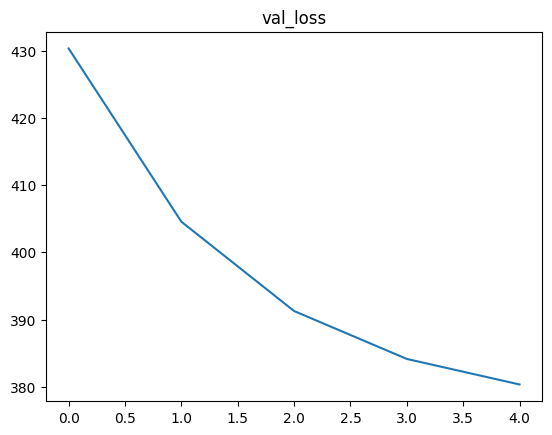

In [ ]:
dict_to_plot(val_loss_dict, 'val_loss')

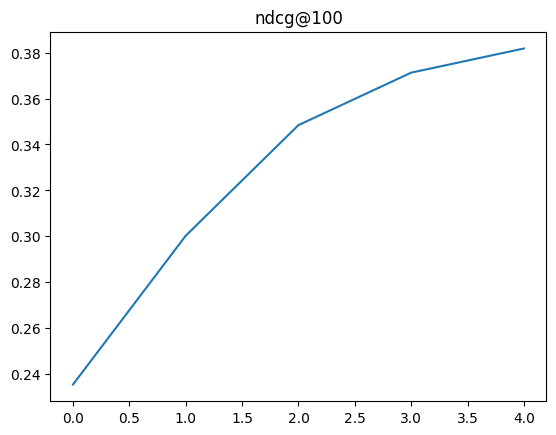

In [ ]:
dict_to_plot(n100_dict, 'ndcg@100')

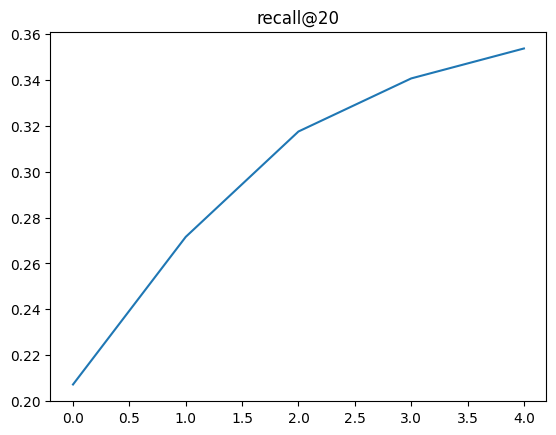

In [ ]:
dict_to_plot(r20_dict, 'recall@20')

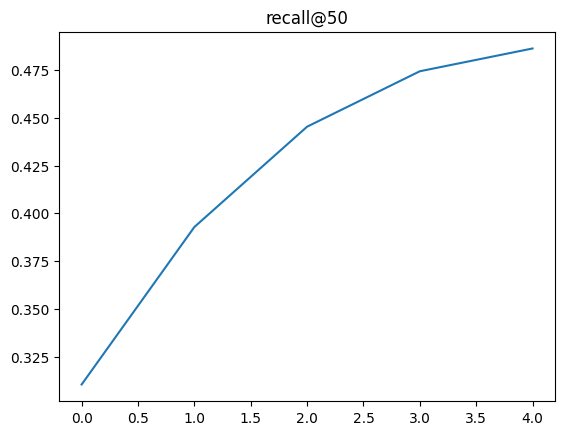

In [ ]:
dict_to_plot(r50_dict, 'recall@50')

## Actividad:

### Parte 1 (2ptos):

Explique de qué se trata el modelo MultVAE.

*RESPUESTA:*

### Parte 2 (4ptos):

Elija uno de las dos versiones del problema de recomendación (con o sin información adicional para usuarios o ítems) e intente mejorar el desempeño de la recomendación. Para esto, pruebe al menos dos combinaciones de hiperparámetros distintas en el problema elegido. Se debe generar una hipótesis de por qué podría mejorar con dicha combinación de hiperparámetros.

PD: Se asignará puntaje completo tanto si se logra o no mejorar la recomendación. Lo importante es que hagan la experimentación.